In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, diffx_tv, diffx_uq, diffy_vq, diffy_tu, filter_apply, filter_iteration, compute_isotropic_KE
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/generalization', additional_subfolder='output')

In [3]:
ds.exps

['R16',
 'R2',
 'R32',
 'R4',
 'R64',
 'R8',
 'R10_EXP205',
 'R10_momf',
 'R10_ref',
 'R12_EXP205',
 'R12_momf',
 'R12_ref',
 'R2_EXP205',
 'R2_momf',
 'R2_ref',
 'R3_EXP205',
 'R3_momf',
 'R3_ref',
 'R4_EXP205',
 'R4_momf',
 'R4_ref',
 'R6_EXP205',
 'R6_momf',
 'R6_ref',
 'R8_EXP205',
 'R8_momf',
 'R8_ref']

In [9]:
for exp in ['R2_ref', 'R3_ref', 'R4_ref', 'R6_ref', 'R8_ref', 'R10_ref', 'R12_ref']:
    ds.remesh('R64',exp)

Experiment R64 coarsegrained to R2_ref is created. Its identificator=R64_R2_ref
Experiment R64 coarsegrained to R3_ref is created. Its identificator=R64_R3_ref
Experiment R64 coarsegrained to R4_ref is created. Its identificator=R64_R4_ref
Experiment R64 coarsegrained to R6_ref is created. Its identificator=R64_R6_ref
Experiment R64 coarsegrained to R8_ref is created. Its identificator=R64_R8_ref
Experiment R64 coarsegrained to R10_ref is created. Its identificator=R64_R10_ref
Experiment R64 coarsegrained to R12_ref is created. Its identificator=R64_R12_ref


In [34]:
def error_ssh(exps):
    bare = np.zeros(len(exps))
    exp205 =  np.zeros(len(exps))
    mom =  np.zeros(len(exps))
    def coarse(x):
        return remesh(x,ds['R2_ref'].h)
    def Lk(x,y):
        return Lk_error(coarse(x),coarse(y),False)[0]
    for j,exp in enumerate(exps):
        bare[j] = Lk(ds[exp+'_ref'].ssh_mean,ds[f'R64_{exp}_ref'].ssh_mean)
        exp205[j] = Lk(ds[exp+'_EXP205'].ssh_mean, ds[f'R64_{exp}_ref'].ssh_mean)
        mom[j] = Lk(ds[exp+'_momf'].ssh_mean, ds[f'R64_{exp}_ref'].ssh_mean)
    return bare, exp205, mom

In [35]:
def error_EKE_spectrum(exps):
    bare = np.zeros(len(exps))
    exp205 =  np.zeros(len(exps))
    mom =  np.zeros(len(exps))
    for j,exp in enumerate(exps):
        bare[j] = sum(Lk_error(ds[exp+'_ref'].EKE_spectrum, ds[f'R64_{exp}_ref'].EKE_spectrum,True))/2
        exp205[j] = sum(Lk_error(ds[exp+'_EXP205'].EKE_spectrum, ds[f'R64_{exp}_ref'].EKE_spectrum,True))/2
        mom[j] = sum(Lk_error(ds[exp+'_momf'].EKE_spectrum, ds[f'R64_{exp}_ref'].EKE_spectrum,True))/2
    return bare, exp205, mom

In [36]:
def error_energetics(exps):
    bare = np.zeros(len(exps))
    exp205 =  np.zeros(len(exps))
    mom =  np.zeros(len(exps))
    for j,exp in enumerate(exps):
        bare[j] = sum(ds[exp+'_ref'].Lk_error(ds[f'R64_{exp}_ref'], features=['EKE_joul','MKE_joul','EPE_joul','MPE_joul'])[0])/6
        exp205[j] = sum(ds[exp+'_EXP205'].Lk_error(ds[f'R64_{exp}_ref'], features=['EKE_joul','MKE_joul','EPE_joul','MPE_joul'])[0])/6
        mom[j] = sum(ds[exp+'_momf'].Lk_error(ds[f'R64_{exp}_ref'], features=['EKE_joul','MKE_joul','EPE_joul','MPE_joul'])[0])/6
    return bare, exp205, mom

In [37]:
exps = ['R2', 'R3', 'R4', 'R6', 'R8', 'R10', 'R12']
ticks = ['$1/2^o$','$1/3^o$','$1/4^o$','$1/6^o$','$1/8^o$', '$1/10^o$', '$1/12^o$']
x = np.arange(len(exps))

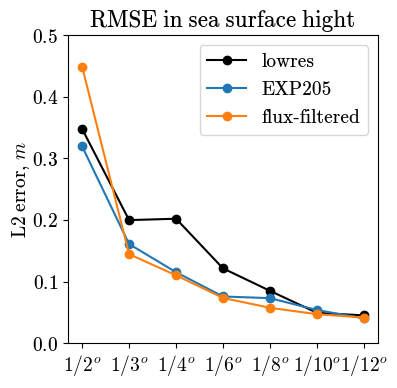

In [38]:
default_rcParams()
bare, exp205, mom = error_ssh(exps)
plt.plot(x,bare,label='lowres',color='k',marker='o')
plt.plot(x,exp205,label='EXP205',marker='o')
plt.plot(x,mom,label='flux-filtered',marker='o')
plt.legend()
plt.xticks(x,ticks)
plt.ylim([0,0.5])
plt.ylabel('L2 error, $m$')
plt.title('RMSE in sea surface hight')
plt.savefig('generalization-ssh.pdf')

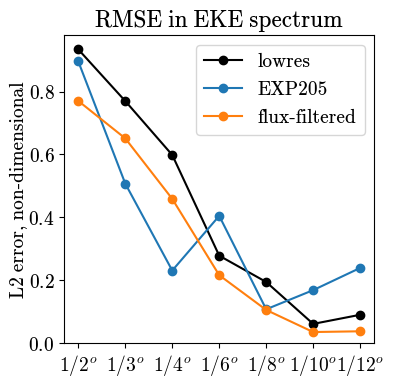

In [20]:
default_rcParams()
bare, exp205, mom = error_EKE_spectrum(exps)
plt.plot(x,bare,label='lowres',color='k',marker='o')
plt.plot(x,exp205,label='EXP205',marker='o')
plt.plot(x,mom,label='flux-filtered',marker='o')
plt.legend()
plt.xticks(x,ticks)
plt.ylabel('L2 error, non-dimensional')
plt.title('RMSE in EKE spectrum')
plt.ylim([0,None])
plt.savefig('generalization-spectrum.pdf')

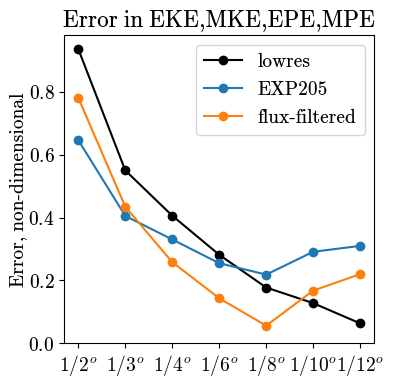

In [21]:
default_rcParams()
bare, exp205, mom = error_energetics(exps)
plt.plot(x,bare,label='lowres',color='k',marker='o')
plt.plot(x,exp205,label='EXP205',marker='o')
plt.plot(x,mom,label='flux-filtered',marker='o')
plt.legend()
plt.xticks(x,ticks)
plt.ylabel('Error, non-dimensional')
plt.title('Error in EKE,MKE,EPE,MPE')
plt.ylim([0,None])
plt.savefig('generalization-energetics.pdf')

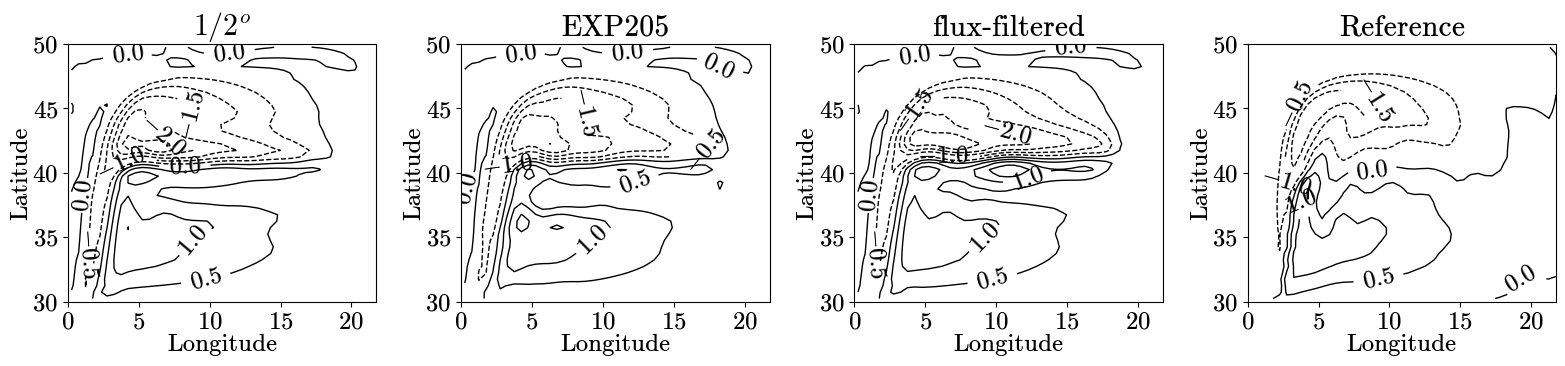

In [63]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R2_ref','R2_EXP205','R2_momf','R64_R2_ref'],labels=['$1/2^o$','EXP205','flux-filtered','Reference'])

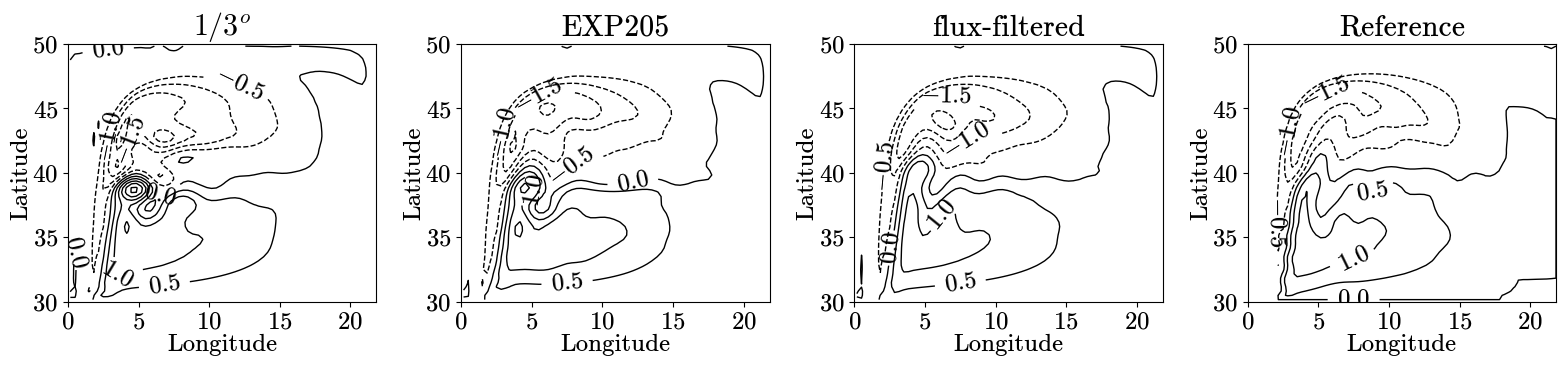

In [93]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R3_ref','R3_EXP205','R3_momf','R64_R3_ref'],labels=['$1/3^o$','EXP205','flux-filtered','Reference'])
plt.savefig('ssh-1-3.pdf')

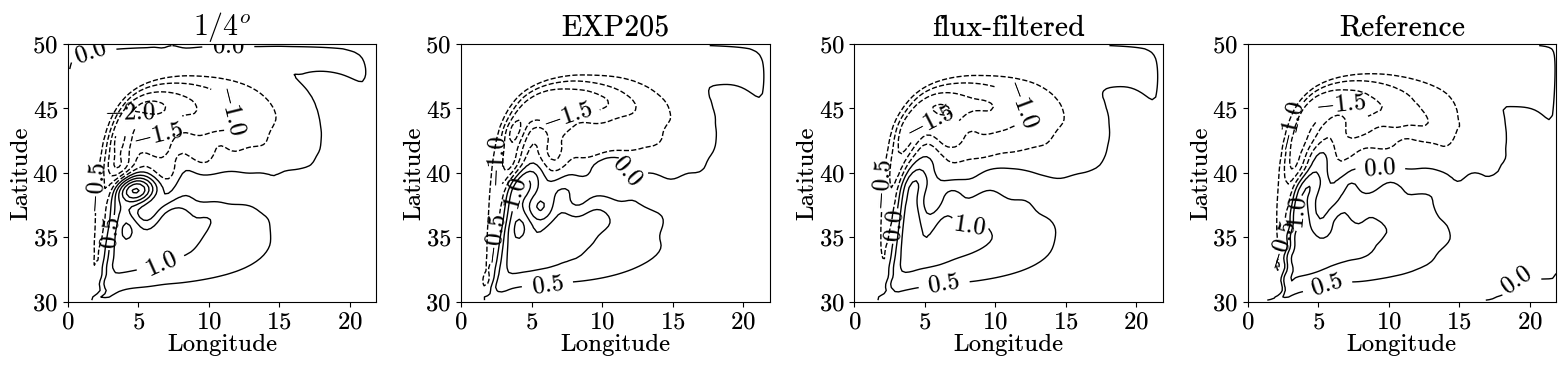

In [94]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R4_ref','R4_EXP205','R4_momf','R64_R4_ref'],labels=['$1/4^o$','EXP205','flux-filtered','Reference'])
plt.savefig('ssh-1-4.pdf')

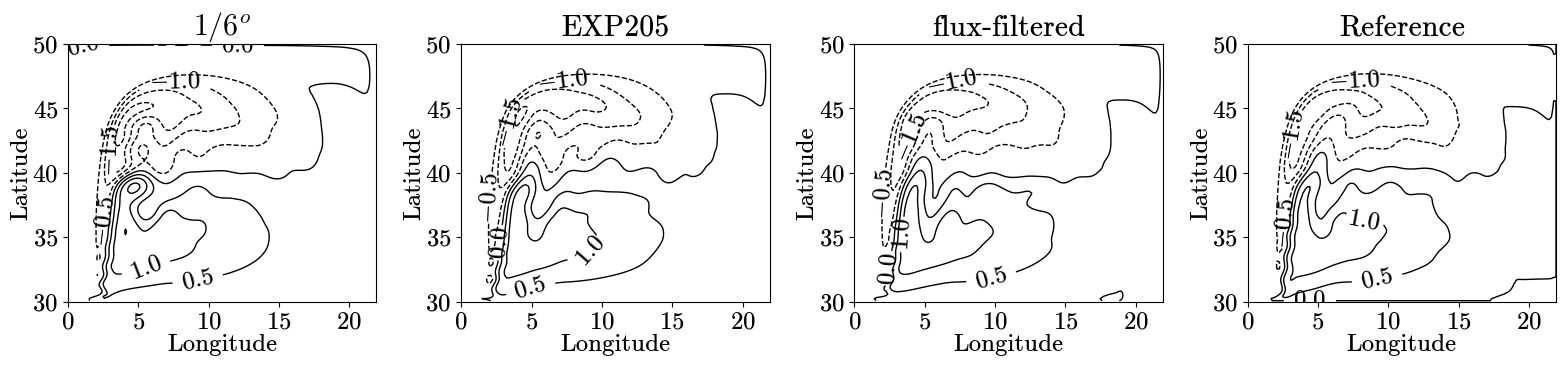

In [66]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R6_ref','R6_EXP205','R6_momf','R64_R6_ref'],labels=['$1/6^o$','EXP205','flux-filtered','Reference'])

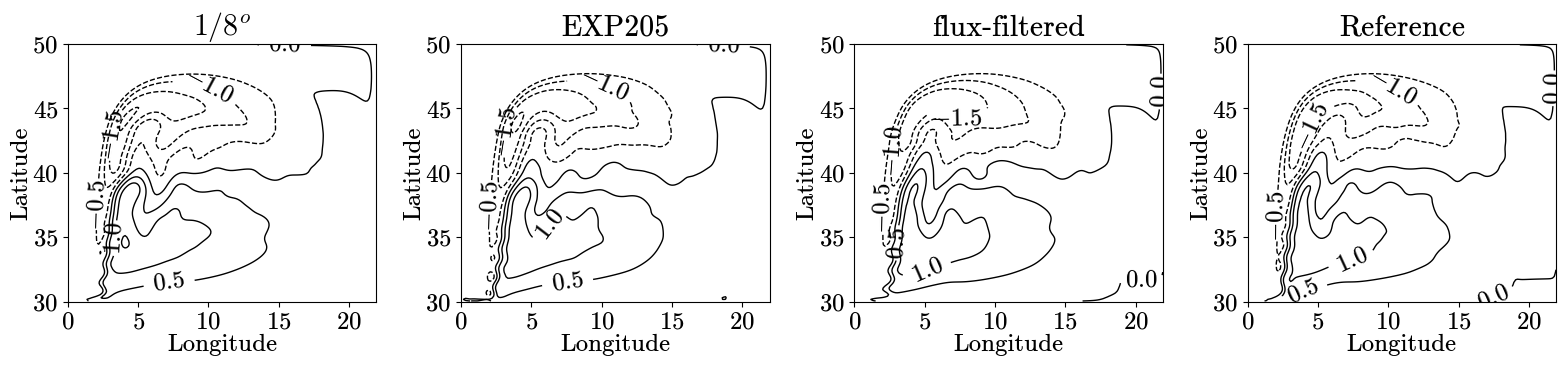

In [95]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R8_ref','R8_EXP205','R8_momf','R64_R8_ref'],labels=['$1/8^o$','EXP205','flux-filtered','Reference'])
plt.savefig('ssh-1-8.pdf')

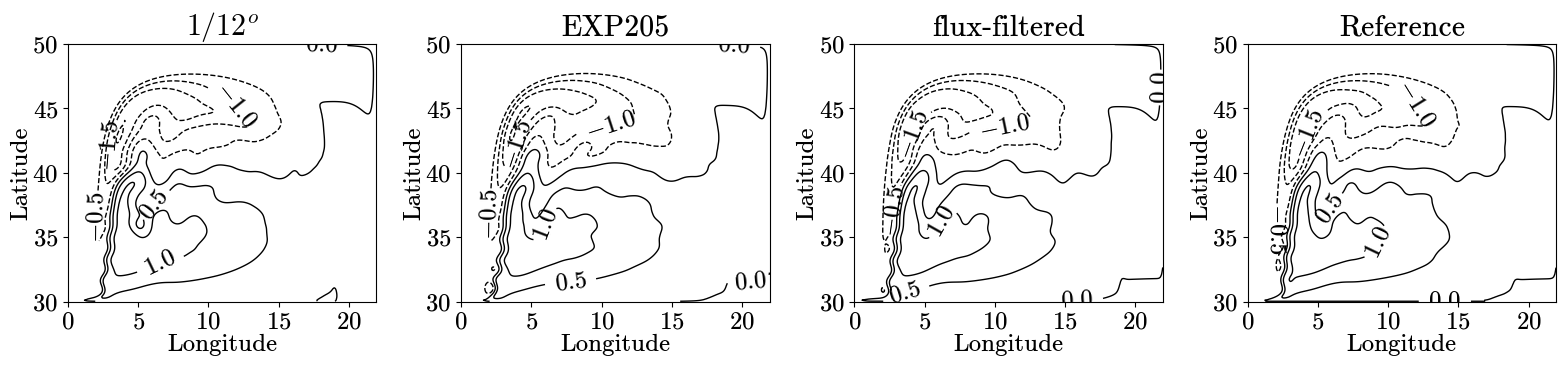

In [24]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R12_ref','R12_EXP205','R12_momf','R64_R12_ref'],labels=['$1/12^o$','EXP205','flux-filtered','Reference'])
plt.savefig('ssh-1-12.pdf')

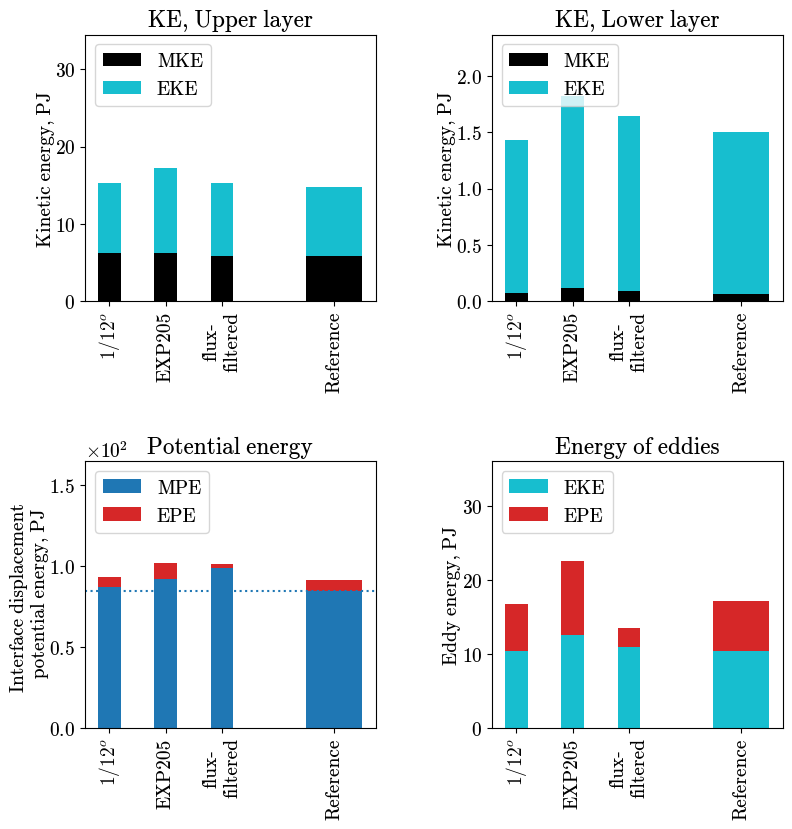

In [39]:
ds.plot_KE_PE(['R12_ref','R12_EXP205','R12_momf','R64_R12_ref'],labels=['$1/12^o$','EXP205','flux-\nfiltered','Reference'])

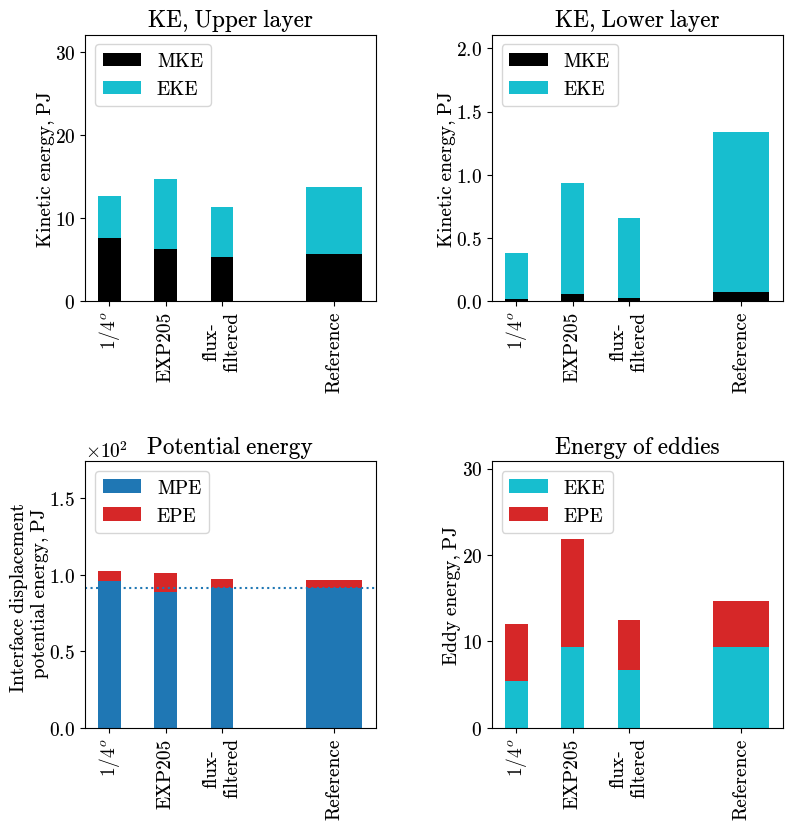

In [40]:
ds.plot_KE_PE(['R4_ref','R4_EXP205','R4_momf','R64_R4_ref'],labels=['$1/4^o$','EXP205','flux-\nfiltered','Reference'])

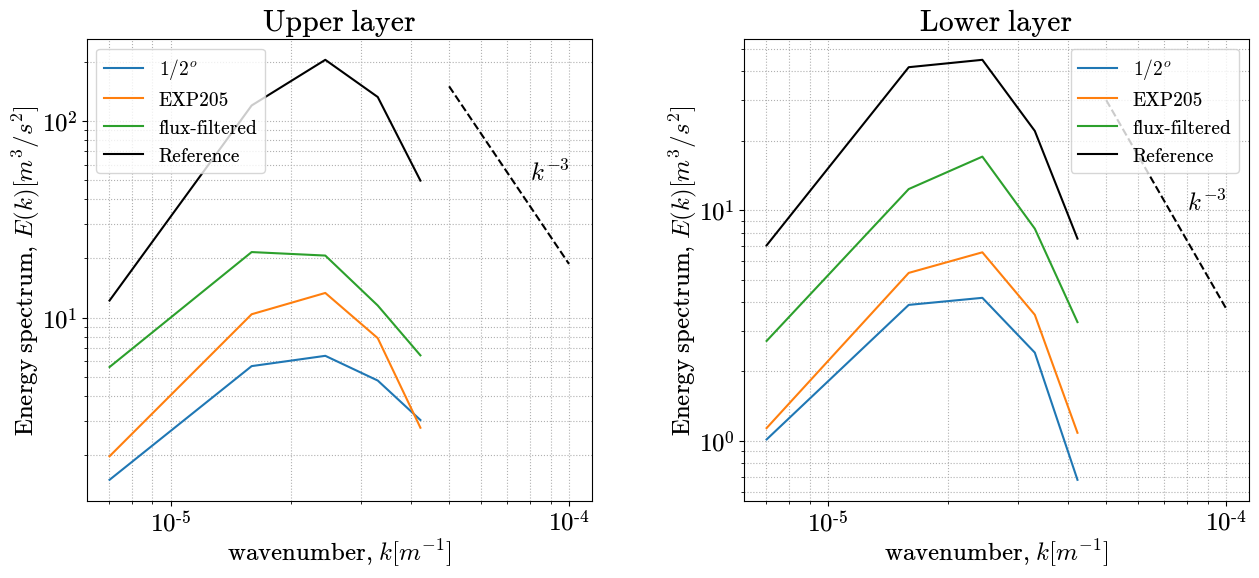

In [69]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R2_ref','R2_EXP205','R2_momf','R64_R2_ref'],labels=['$1/2^o$','EXP205','flux-filtered','Reference'])

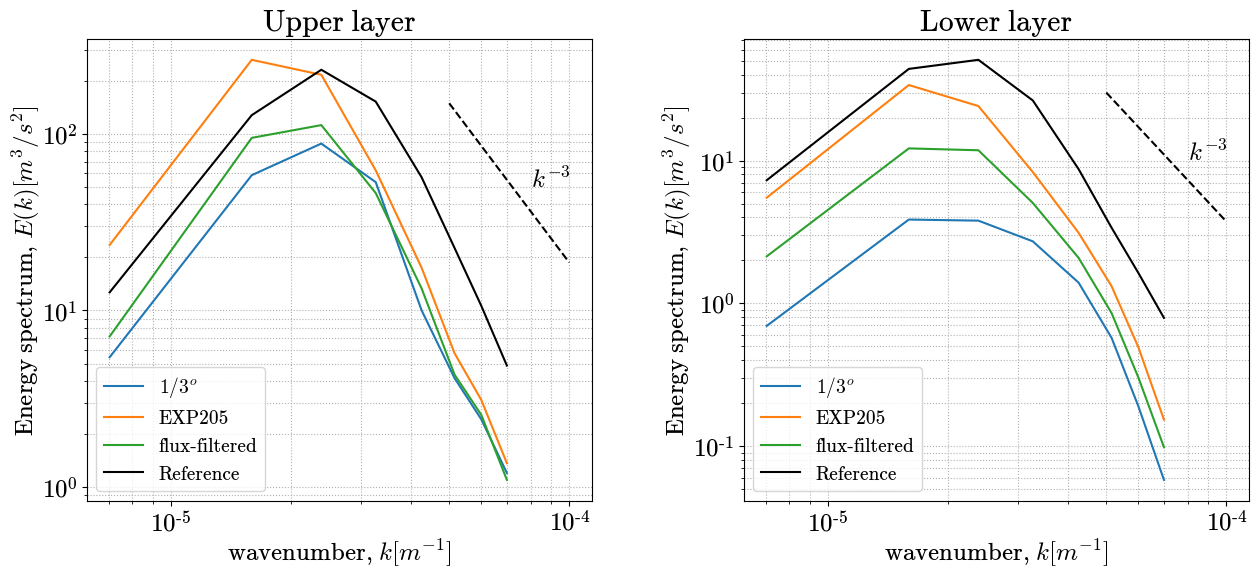

In [96]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R3_ref','R3_EXP205','R3_momf','R64_R3_ref'],labels=['$1/3^o$','EXP205','flux-filtered','Reference'])
plt.savefig('sp-1-3.pdf')

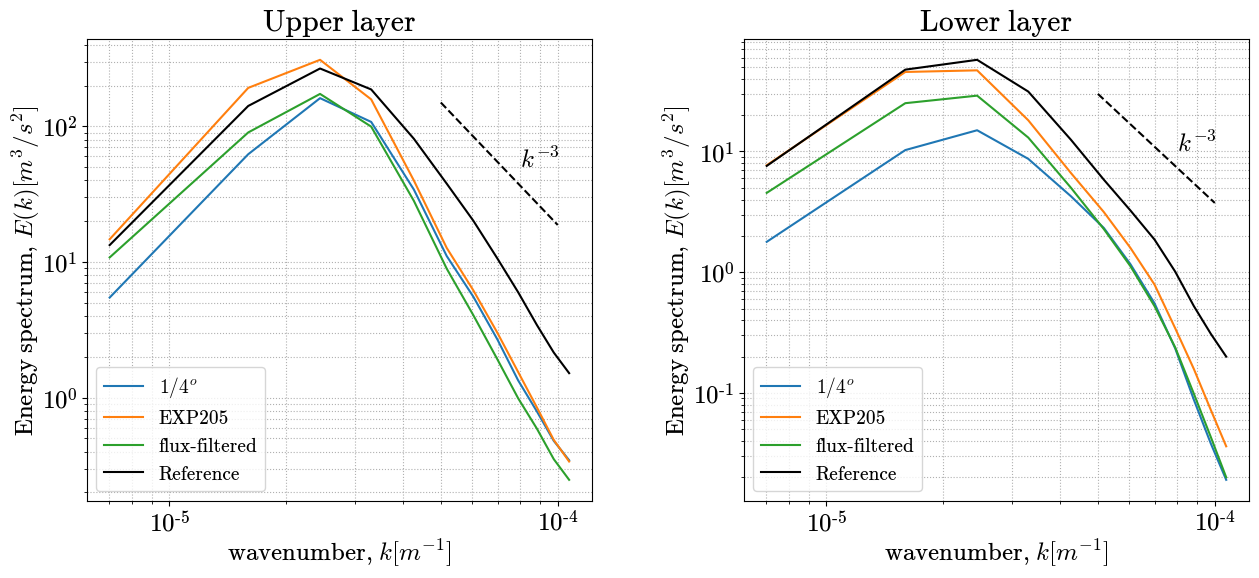

In [97]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R4_ref','R4_EXP205','R4_momf','R64_R4_ref'],labels=['$1/4^o$','EXP205','flux-filtered','Reference'])
plt.savefig('sp-1-4.pdf')

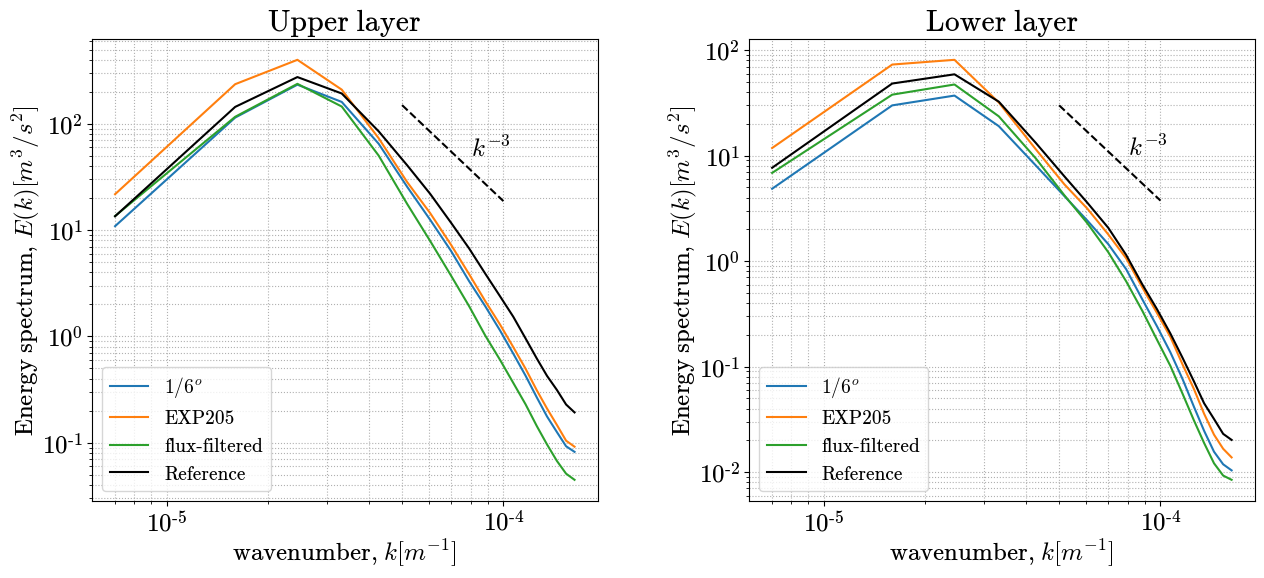

In [98]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R6_ref','R6_EXP205','R6_momf','R64_R6_ref'],labels=['$1/6^o$','EXP205','flux-filtered','Reference'])
plt.savefig('sp-1-6.pdf')

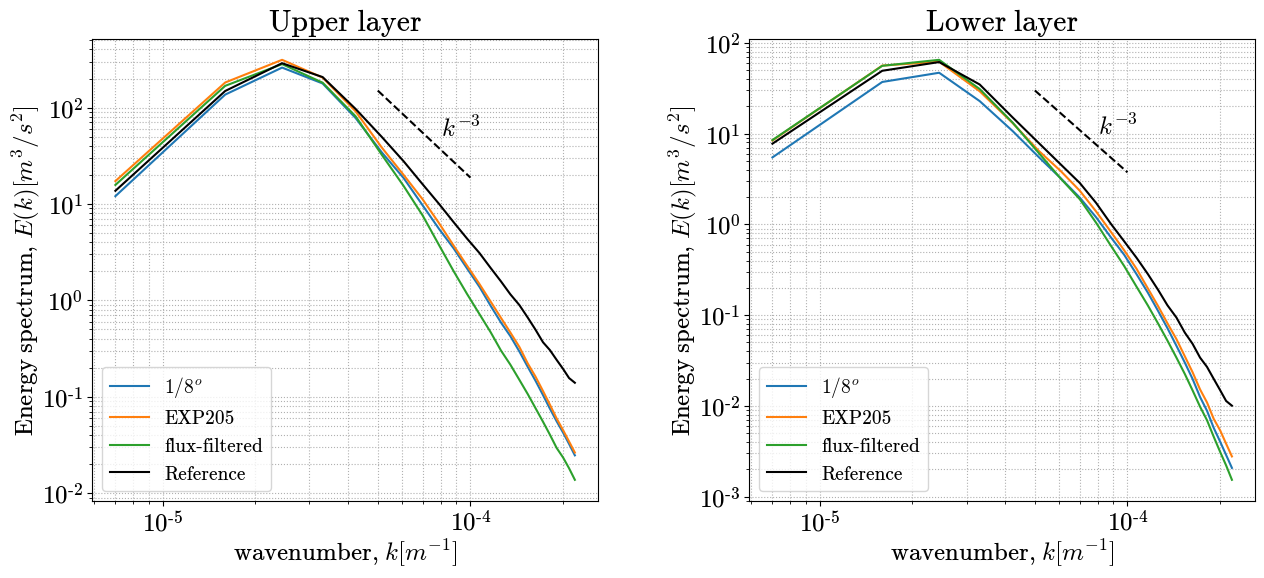

In [89]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R8_ref','R8_EXP205','R8_momf','R64_R8_ref'],labels=['$1/8^o$','EXP205','flux-filtered','Reference'])

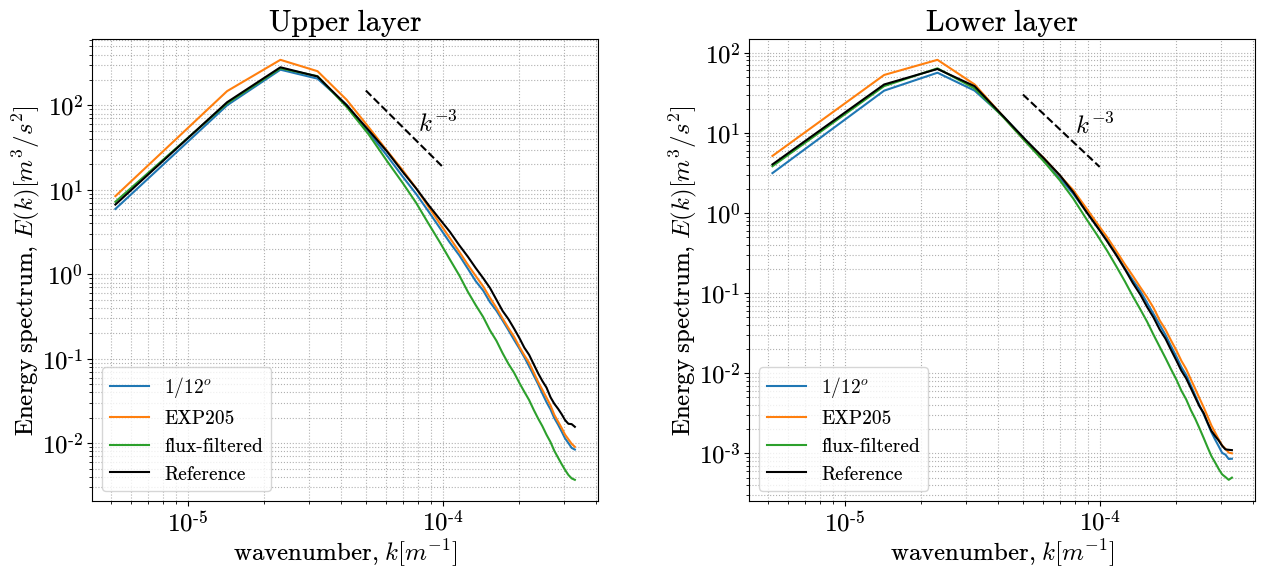

In [22]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R12_ref','R12_EXP205','R12_momf','R64_R12_ref'],labels=['$1/12^o$','EXP205','flux-filtered','Reference'])

# Driving small scales

In [15]:
def KEspectrum(key):
    exp = ds[key]
    return compute_isotropic_KE(exp.u, exp.v, exp.param.dxT, exp.param.dyT, Lat=(30,50), Lon=(0,22), window=None, detrend=None, window_correction=False).sel(Time=slice(3650,7300)).mean(dim='Time')

In [16]:
ref = KEspectrum('R64_R4_ref').compute()

In [28]:
hires = KEspectrum('R32').compute()

In [17]:
coarse = KEspectrum('R4_ref').compute()

In [18]:
exp205 = KEspectrum('R4_EXP205').compute()

In [19]:
mom = KEspectrum('R4_momf').compute()

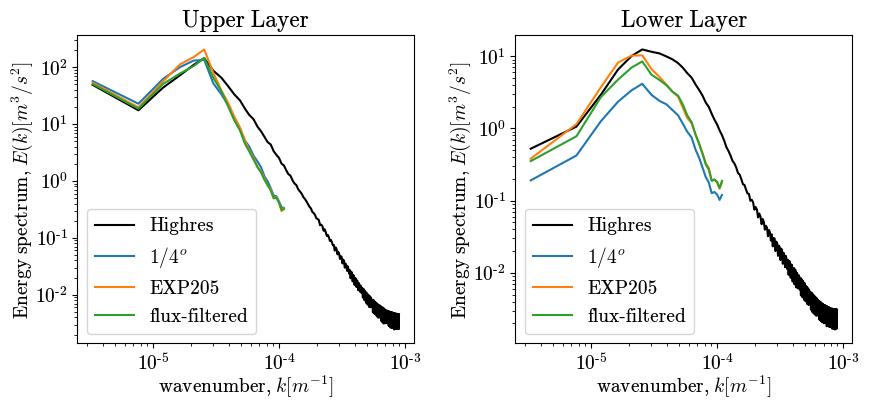

In [35]:
default_rcParams()
plt.figure(figsize=(10,4))
for zl in range(2):
    plt.subplot(1,2,zl+1)
    hires.isel(zl=zl).plot(label='Highres', color='k',xscale='log',yscale='log')
    coarse.isel(zl=zl).plot(label='$1/4^o$')
    exp205.isel(zl=zl).plot(label='EXP205')
    mom.isel(zl=zl).plot(label='flux-filtered')
    plt.legend()
    if zl==0:
        plt.title('Upper Layer')
    else:
        plt.title('Lower Layer')
    plt.xlabel(r'wavenumber, $k [m^{-1}]$')
    plt.ylabel(r'Energy spectrum, $E(k) [m^3/s^2]$')
plt.savefig('global_spectrum.pdf')

# Optimization of the filter
* Let typical resolution be 100x100 points
* Target filter:
\begin{equation}
    \mathrm{filter}(\phi_x,\phi_y) = \begin{cases}
                1, &\phi < 0.65 \pi \\
                \exp (-23.6 (\phi - 0.65 \pi)^4), & \text{otherwise}
            \end{cases}
\end{equation}
* Filter to be optimized:
\begin{equation}
    u_{\mathbf{k}}^{t+1} = u_{\mathbf{k}}^{t} \left( 1 - 4 \alpha \left( \sin^2(\frac{\phi_x}{2}) + \sin^2(\frac{\phi_y}{2}) \right) \cdot
    HPF(\phi_x,\phi_y)\right)
\end{equation}
* Where
\begin{equation}
    HPF(\phi_x,\phi_y) = \left(1-\left(\frac{1}{4} \left(1+\cos(\phi_x)\right) \left(1+\cos(\phi_y)\right)\right)\right)^n.
\end{equation}
* Setting chess harmonic to zero, we get $\alpha=1/8$; But we let it be a free parameter

In [45]:
px, py = np.meshgrid(np.linspace(0,np.pi,50),np.linspace(0,np.pi,50))

In [225]:
def contour(x,y,z):
    plt.contourf(x,y,z,levels=[0,0.25,0.5,0.75,0.9,0.95,0.99,1])
    Cplot = plt.contour(x,y,z,levels=[0,0.25,0.5,0.75,0.9,0.95,0.99],colors='k')
    plt.gca().clabel(Cplot, Cplot.levels)
    plt.xticks([0,np.pi/3,2*np.pi/3,np.pi],['$0$','$\pi/3$','$2\pi/3$','$\pi$'])
    plt.yticks([0,np.pi/3,2*np.pi/3,np.pi],['$0$','$\pi/3$','$2\pi/3$','$\pi$'])

In [248]:
def half_life(x,y,z):
    z = np.log(1/2)/np.log(z)
    levels = [1, 2, 5, 10, 50, 100,1000]
    #plt.contourf(x,y,z,levels=levels)
    Cplot = plt.contour(x,y,z,levels=levels,colors='k')
    plt.gca().clabel(Cplot, Cplot.levels)
    plt.xticks([0,np.pi/4, np.pi/2,2*np.pi/3,np.pi],['$0$','$\pi/4$', '$\pi/2$','$2\pi/3$','$\pi$'])
    plt.yticks([0,np.pi/4, np.pi/2,2*np.pi/3,np.pi],['$0$','$\pi/4$', '$\pi/2$','$2\pi/3$','$\pi$'])

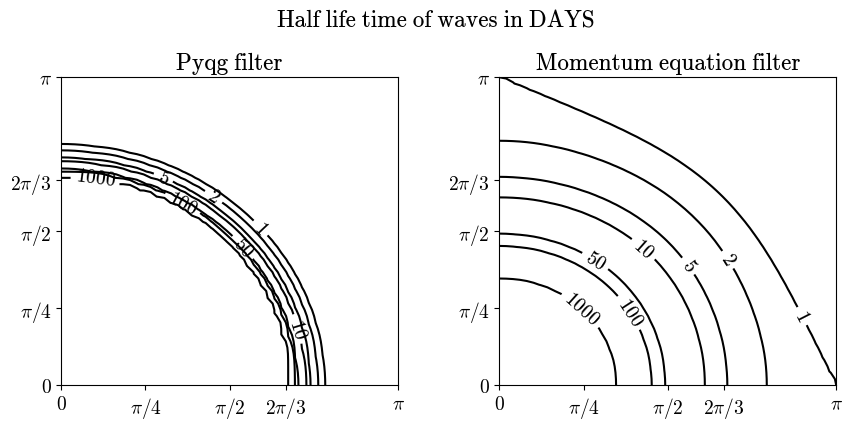

In [249]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
half_life(px,py,target(px,py))
plt.title('Pyqg filter')
plt.subplot(1,2,2)
half_life(px,py,lapfilter(px,py,n=4,alpha=1/8));
plt.title('Momentum equation filter')
plt.suptitle('Half life time of waves in DAYS', y=1.05)
plt.savefig('half-time.pdf')

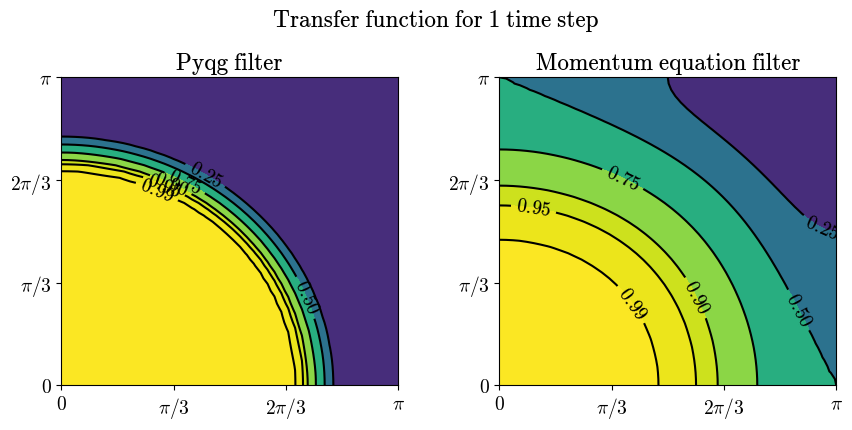

In [247]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
contour(px,py,target(px,py))
plt.title('Pyqg filter')
plt.subplot(1,2,2)
contour(px,py,lapfilter(px,py,n=4,alpha=1/8));
plt.title('Momentum equation filter')
plt.suptitle('Transfer function for 1 time step', y=1.05)
plt.savefig('transfer-function.pdf')

In [140]:
def target(px,py):
    cphi=0.65*np.pi
    phi = np.sqrt(px**2+py**2)
    filtr = np.exp(-23.6*(phi-cphi)**4.)
    filtr[phi<=cphi] = 1.
    return filtr

In [141]:
def HPF(px,py,n=1):
    return (1 - 1/4*(1+np.cos(px))*(1+np.cos(py)))**float(n)

In [142]:
def lapfilter(px,py,n=1,alpha=1/8):
    return 1-4*alpha*((np.sin(px/2))**2.+(np.sin(py/2))**2.)*HPF(px,py,n)

In [143]:
def L2_metric(n=1,alpha=1/8,nsteps=1):
    error = (target(px,py))**float(nsteps) - (lapfilter(px,py,n,alpha))**float(nsteps)
    return np.sqrt((error**2).mean())

In [159]:
for n in range(11):
    print(n, L2_metric(n,nsteps=1))

0 0.29966245635009686
1 0.2741038993931576
2 0.2724053766102314
3 0.2799538504439871
4 0.29113744402796526
5 0.30351310506440904
6 0.31597301630587493
7 0.32801530251573047
8 0.33942558625922004
9 0.3501296404463875
10 0.3601221109885186


In [151]:
L2_metric(n=8,nsteps=10)

0.10465721462030667

In [202]:
0.99**68

0.5048858887870696

In [201]:
np.log(1/2)/np.log(0.99)

68.96756393652842